In [1]:
import random
import itertools as it
from pathlib import Path

import mido
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

from notepredictor import PitchPredictor

In [29]:
# data_dir = Path('/Users/victor/Downloads/lmd_full')
# files = list(data_dir.glob('**/*.mid'))

In [30]:
# try:
#     mid = mido.MidiFile(random.choice(files))
# except Exception as e:
#     print(e, e.msg)
# tempos = {m.tempo for tr in mid.tracks for m in tr if m.type=='set_tempo'}
# tuple(tempos)[0] / mid.ticks_per_beat / 1e6
# mid.tracks[1]


In [31]:
data_dir = Path('/Users/victor/data/lmd_prep')

In [63]:
class LakhMIDI(torch.utils.data.IterableDataset):
    def __init__(self, data_dir, batch_len=None):
        super().__init__()
        self.files = list(Path(data_dir).glob('**/*.pkl'))
        self.batch_len = batch_len
        
    def __iter__(self):
        return self
    
    def __next__(self):
        while True:
            f = random.choice(self.files)
            item = torch.load(f)
            notes = item['pitch']
            if len(notes) >= self.batch_len:
                i = random.randint(0, len(notes)-self.batch_len)
                return notes[i:i+self.batch_len]

In [64]:
batch_size = 64
batch_len = 64

ds = LakhMIDI(data_dir, batch_len)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, num_workers=0, collate_fn=torch.stack)

In [65]:
%%time
next(iter(dl)).shape

CPU times: user 42.3 ms, sys: 32.6 ms, total: 74.9 ms
Wall time: 114 ms


torch.Size([64, 64])

In [66]:
net = PitchPredictor()

In [67]:
opt = torch.optim.Adam(net.parameters(), 1e-3)
losses = []

In [43]:
len(dl.dataset.files)

53848

512it [08:03,  1.06it/s]


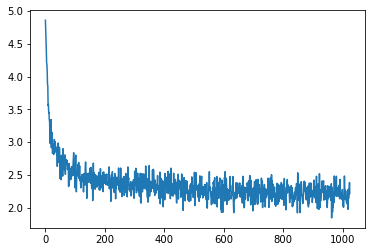

In [71]:
# %%prun

for batch in tqdm(it.islice(dl,512)):
    # batch = torch.LongTensor([notes for notes in it.islice(gen_tracks(batch_len), batch_size)])
    opt.zero_grad()
    r = net(batch)
    nll = (-r['log_probs']).mean()
    nll.backward()
    opt.step()
    losses.append(nll.item())
plt.plot(losses)

In [746]:
torch.save(net.state_dict(), 'pitch_lakh_32k.pt')

In [70]:
%%time
acc = 0
m = 64
ds_it = iter(ds)
for _ in range(m):
    notes = next(ds_it)
    n = len(notes)-1
    net.reset()
    acc += sum(net.predict(notes[i])==notes[i+1] for i in range(n))/n
acc/m

CPU times: user 2.98 s, sys: 49.7 ms, total: 3.03 s
Wall time: 3.24 s


tensor(0.2185)

In [72]:
batch_size*len(losses) / len(ds.files)

0.6393257111640067

In [716]:
%%timeit
net.predict(0)

407 µs ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [74]:
net_probs = []
for a in range(128):
    net.reset()
    b = net.predict(a, sample=False)
    net_probs.append(b)
net_probs = torch.stack(net_probs, 0)

Text(0.5, 1.0, 'P(b|a)')

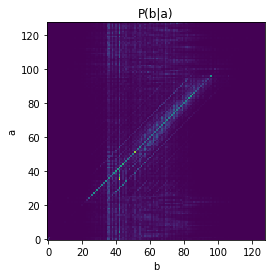

In [75]:
plt.imshow(net_probs.data, origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('P(b|a)')

# unigram baseline

In [81]:
counts = torch.zeros(128,128).long()
for s in ds:
    counts[s[:-1], s[1:]] += 1

KeyboardInterrupt: 

Text(0.5, 1.0, 'P(b|a)')

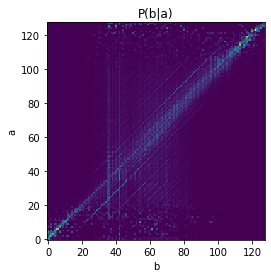

In [82]:
#P(b|a)
probs = counts / counts.sum(1,keepdims=True)
probs#[40:60, 40:60]
plt.imshow(probs, origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('P(b|a)')

<BarContainer object of 128 artists>

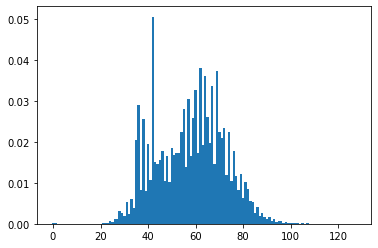

In [83]:
marg = counts.sum(1) / counts.sum()
plt.bar(range(128), marg, width=1)

In [84]:
# baseline accuracy
(probs.max(1).values * marg).sum()

tensor(0.0877)

<BarContainer object of 128 artists>

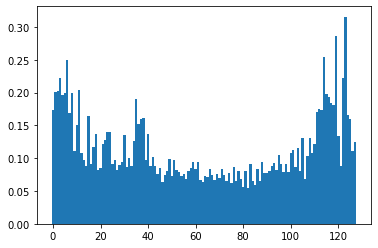

In [85]:
plt.bar(range(128), probs.max(1).values, width=1)